In [1]:
"""
Created on Wed Mar  8 12:04:48 2023
@author: Ahmad Al Musawi
"""

from sklearn.manifold import SpectralEmbedding
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from scipy import stats
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score



In [2]:
def split_labels(df, cols):
    '''split the dataframe into predicting table and labels
       df: given dataset
       cols: list of labels
    '''
    return df[[i for i in df if i not in cols]], df[cols]

In [3]:
def LinearSVM(X_train,y_train, X_test):
    clf = LinearSVC(random_state=42)
    clf.fit(X_train, y_train)
    
    # make predictions on the test set
    y_pred = clf.predict(X_test)
    return y_pred

def GaussianSVM(X_train,y_train, X_test):
#     print('implementing SVM...')
    clf = SVC(kernel='rbf', C=1.0) # Gaussian radial basis function (RBF) kernel
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return y_pred

def PolySVM(X_train,y_train, X_test):
#     print('implementing SVM...')
    clf = SVC(kernel='poly', degree=2, coef0=1, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return y_pred

def SigmoidSVM(X_train,y_train, X_test):
#     print('implementing SVM...')
    clf = SVC(kernel='sigmoid', gamma='scale', random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return y_pred

def NaiveBayes(X_train,y_train, X_test):
#     print('implementing Naive Bayes...')
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return y_pred

def Logistic(X_train,y_train, X_test):
#     print('implementing Logistic Regression...')
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    
    # make predictions on the test set
    y_pred = clf.predict(X_test)    
    return y_pred

   
def CART(X_train,y_train, X_test):
#     print('implementing CART...')
    clf = DecisionTreeClassifier(max_depth=5)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return y_pred

def kNN(X_train,y_train, X_test):
#     print('implementing kNN...')
    from sklearn.neighbors import KNeighborsClassifier

    # assuming X is your data and k is the number of clusters
    clf = KNeighborsClassifier(n_neighbors=10)
    clf.fit(X_train, y_train)
    return clf.predict(X_test)

In [4]:
def one_split(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    return X_train, X_test, y_train, y_test 

def get_classification_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]
    sensitivity = []
    specificity = []
    for i in range(num_classes):
        tp = cm[i,i]
        fn = np.sum(cm[i,:]) - tp
        fp = np.sum(cm[:,i]) - tp
        tn = np.sum(cm) - tp - fp - fn
        
        sensitivity_i = tp / (tp + fn)
        specificity_i = tn / (tn + fp)
        sensitivity.append(sensitivity_i)
        specificity.append(specificity_i)
    
    macro_sensitivity = np.mean(sensitivity)
    macro_specificity = np.mean(specificity)
    
    return accuracy, macro_sensitivity, macro_specificity

def predict(X,Y, predictors):
    X_train, X_test, y_train, y_test = one_split(X, Y)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    pred_Y = [pred(X_train,y_train, X_test) for pred in predictors]
    return [get_classification_metrics(y_test, p) for p in pred_Y]


In [5]:
df1 = pd.read_csv('heart.csv')

# Preprocessing
dataset = df1
from pandas import get_dummies
a = pd.get_dummies(dataset['sex'], prefix = "sex")
b = pd.get_dummies(dataset['cp'], prefix = "cp")
c = pd.get_dummies(dataset['fbs'], prefix = "fbs")
d = pd.get_dummies(dataset['restecg'], prefix = "restecg")
e = pd.get_dummies(dataset['exang'], prefix = "exang")
f = pd.get_dummies(dataset['slope'], prefix = "slope")
g = pd.get_dummies(dataset['ca'], prefix = "ca")
h = pd.get_dummies(dataset['thal'], prefix = "thal")

frames = [dataset, a, b, c, d, e, f, g, h]
dataset2 = pd.concat(frames, axis = 1)
dataset2 = dataset2.drop(columns = ['sex','cp', 'fbs', 'restecg','exang','slope','ca','thal'])

df1 = dataset2
X1, Y1 = split_labels(df1, ['target'])

In [6]:
df2 = pd.read_excel('CTG.xls', sheet_name = 'Raw Data')

df2 = df2[[i for i in df2 if i not in ['FileName','Date','SegFile']]]

X2, Y2 = split_labels(df2, ['NSP'])

nX2 = stats.zscore(X2)

In [7]:
predictors = [LinearSVM, GaussianSVM, PolySVM, SigmoidSVM, NaiveBayes, Logistic, CART, kNN]
predictorsTXT = ['LinearSVM', 'GaussianSVM', 'PolySVM', 'SigmoidSVM', 'NaiveBayes', 'Logistic', 'CART', 'kNN']

results1 = predict(X1, Y1, predictors)
results2 = predict(X2, Y2, predictors)

print('Heart Disease')
acc, sen, spe  = [],[],[]
for a, s, e in results1:
    acc.append(a)
    sen.append(s)
    spe.append(e)
print(pd.DataFrame({'model': predictorsTXT,'accuracy': acc, 'sensitivity': sen, 'specificity': spe}))


print('Heart Disease2')
acc, sen, spe = [],[],[]
for a, s, e  in results2:
    acc.append(a)
    sen.append(s)
    spe.append(e)
print(pd.DataFrame({'model': predictorsTXT,'accuracy': acc, 'sensitivity': sen, 'specificity': spe}))

D:\Documents\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Documents\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Documents\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Documents\anaconda3\lib\site-packages\

Heart Disease
         model  accuracy  sensitivity  specificity
0    LinearSVM  0.814935     0.816323     0.816323
1  GaussianSVM  0.918831     0.919484     0.919484
2      PolySVM  0.870130     0.870837     0.870837
3   SigmoidSVM  0.795455     0.797877     0.797877
4   NaiveBayes  0.733766     0.740239     0.740239
5     Logistic  0.798701     0.799755     0.799755
6         CART  0.879870     0.882593     0.882593
7          kNN  0.863636     0.863704     0.863704
Heart Disease2
         model  accuracy  sensitivity  specificity
0    LinearSVM  0.989028     0.979953     0.990475
1  GaussianSVM  0.985893     0.973352     0.985780
2      PolySVM  0.989028     0.979953     0.990475
3   SigmoidSVM  0.957680     0.933625     0.968573
4   NaiveBayes  0.913793     0.947695     0.960680
5     Logistic  0.989028     0.979953     0.990475
6         CART  0.973354     0.967976     0.980814
7          kNN  0.985893     0.973352     0.985780


D:\Documents\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Documents\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Documents\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Documents\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [34]:
def PCA_model(X, y=None, n = 2):
#     print("PCA model")
    pca = PCA(n_components=n)
    pca.fit(X)
    X_pca = pca.transform(X)
    print(pca.explained_variance_ratio_)
    selected_features = pca.components_
#     print(f'PCA\tNoF = {len(selected_features)}')
    return X_pca

def Kernel_PCA(X, y=None, n = 2):
    from sklearn.decomposition import KernelPCA
#     print("Kernal PCA model")
    pca = KernelPCA(n_components=n, kernel='rbf')
    pca.fit_transform(X)
    return pca

def CE_Model(X, y=None, n=2):
    # Compute the spectral embedding using the Gaussian kernel
    sigma = 0.1
    embedding_gaussian = SpectralEmbedding(n_components=n, affinity='rbf', gamma=1 / (2 * sigma ** 2))
#     embedding = embedding_gaussian(n_components=n)
    X_CE = embedding_gaussian.fit_transform(X)
    return X_CE

def CE2(X, y=None, n=2):
    embedding = SpectralEmbedding(n_components=n, affinity='nearest_neighbors', n_neighbors=10, eigen_solver='arpack')
    X_CE = embedding.fit_transform(X)
#     print(f'CE2\tOld shape = {X.shape}\t\t new shape = {X_CE.shape}\t\t components = {n}')
    return X_CE

def LLE(X, y=None, n=2):
    from sklearn.manifold import LocallyLinearEmbedding
#     print('CE Model: Locally Linear Embedding')
    embedding = LocallyLinearEmbedding(n_components=n, n_neighbors=10)
    X_CE = embedding.fit_transform(X)
#     print(f'LLE\tOld shape = {X.shape}\t\t new shape = {X_CE.shape}\t\t components = {n}')
    return X_CE

def Isomap(X, y=None, n=2):
    from sklearn.manifold import Isomap
#     print('CE Model: Isomap')
    embedding =  Isomap(n_components=n, n_neighbors=10)
    X_CE = embedding.fit_transform(X)
#     print(f'ISOMAP\tOld shape = {X.shape}\t\t new shape = {X_CE.shape}\t\t components = {n}')
    return X_CE

def TSNE(X, y=None, n=2):
    from sklearn.manifold import TSNE
#     print('CE Model: TSNE')
    embedding = TSNE(n_components=2, perplexity=30, n_iter=1000)
    X_CE = embedding.fit_transform(X)
#     print(f'TSNE\tOld shape = {X.shape}\t\t new shape = {X_CE.shape}\t\t components = {n}')
    return X_CE



def CFS(X, y, n=2):
#     print('CFS Model')
    selector = SelectKBest(score_func=f_regression, k=n)
    X_new = selector.fit_transform(X, y)
    return X_new

def LLCFS(X, y=None,n=2):
#     print('LLCFS Model')
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X

def ILFS(X, y, n=2):
    # create a linear regression model
#     print('ILFS Model')
    model = LinearRegression()
    
    # define the search space
    k_features = np.arange(1, X.shape[1]+1)
    
    # create a sequential feature selector object
    selector = SequentialFeatureSelector(model, k_features=k_features, forward=True, scoring='r2', cv=5)
    
    # perform incremental feature selection
    selector.fit(X, y)
    
    # print the selected feature indices
    print("Indices of selected features:", selector.k_feature_idx_)
    return selector.k_feature_idx_

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, average_precision_score

In [35]:
predictors = [LinearSVM, GaussianSVM, PolySVM, SigmoidSVM, NaiveBayes, Logistic, CART, kNN]
predictorsTXT = ['LinearSVM', 'GaussianSVM', 'PolySVM', 'SigmoidSVM', 'NaiveBayes', 'Logistic', 'CART', 'kNN']

In [36]:
# performing experiment 2    

DR = [ CFS, LLCFS, PCA_model, CE_Model, CE2, LLE, Isomap, TSNE]
DR_TXT = [ 'CFS', 'LLCFS', 'PCA_model', 'CE_Model', 'CE2', 'LLE', 'Isomap', 'TSNE']

print(X1.shape)
All = {}
for NoF in range (2, X1.shape[1], 2): # Number of features
    X1s = [d(X1, np.ravel(Y1), NoF) for d in DR] # dimension reduction
    results1 = [predict(x1, np.ravel(Y1), [GaussianSVM])[0] for x1 in X1s] # Machine learning models
    All[NoF] = results1
    

print('complete.....\n\n')

(1025, 30)
[0.74525027 0.15198944]


D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
D:\Documents\anaconda3\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initial

[0.74525027 0.15198944 0.08492128 0.0164983 ]


D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
D:\Documents\anaconda3\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initial

[7.45250270e-01 1.51989441e-01 8.49212797e-02 1.64983040e-02
 3.79041061e-04 1.68144799e-04]


D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
D:\Documents\anaconda3\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initial

[7.45250270e-01 1.51989441e-01 8.49212797e-02 1.64983040e-02
 3.79041061e-04 1.68144814e-04 1.31375726e-04 1.07866598e-04]


D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
D:\Documents\anaconda3\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initial

[7.45250270e-01 1.51989441e-01 8.49212797e-02 1.64983040e-02
 3.79041061e-04 1.68144814e-04 1.31375727e-04 1.07866598e-04
 9.27031645e-05 8.02546887e-05]


D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
D:\Documents\anaconda3\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initial

[7.45250270e-01 1.51989441e-01 8.49212797e-02 1.64983040e-02
 3.79041061e-04 1.68144814e-04 1.31375727e-04 1.07866598e-04
 9.27031645e-05 8.02546887e-05 7.18502447e-05 6.69134612e-05]


D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
D:\Documents\anaconda3\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initial

[7.45250270e-01 1.51989441e-01 8.49212797e-02 1.64983040e-02
 3.79041061e-04 1.68144814e-04 1.31375727e-04 1.07866598e-04
 9.27031645e-05 8.02546887e-05 7.18502447e-05 6.69134612e-05
 6.06049535e-05 4.64435282e-05]


D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
D:\Documents\anaconda3\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initial

[7.45250270e-01 1.51989441e-01 8.49212797e-02 1.64983040e-02
 3.79041061e-04 1.68144814e-04 1.31375727e-04 1.07866598e-04
 9.27031645e-05 8.02546887e-05 7.18502447e-05 6.69134612e-05
 6.06049535e-05 4.64435282e-05 3.62096578e-05 2.45265630e-05]


D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
D:\Documents\anaconda3\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initial

[7.45250270e-01 1.51989441e-01 8.49212797e-02 1.64983040e-02
 3.79041061e-04 1.68144814e-04 1.31375727e-04 1.07866598e-04
 9.27031645e-05 8.02546887e-05 7.18502447e-05 6.69134612e-05
 6.06049535e-05 4.64435282e-05 3.62096578e-05 2.45265630e-05
 2.29950682e-05 1.94622818e-05]


D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
D:\Documents\anaconda3\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initial

[7.45250270e-01 1.51989441e-01 8.49212797e-02 1.64983040e-02
 3.79041061e-04 1.68144814e-04 1.31375727e-04 1.07866598e-04
 9.27031645e-05 8.02546887e-05 7.18502447e-05 6.69134612e-05
 6.06049535e-05 4.64435282e-05 3.62096578e-05 2.45265630e-05
 2.29950682e-05 1.94622818e-05 1.90456946e-05 5.57160064e-06]


D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
D:\Documents\anaconda3\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initial

[7.45250270e-01 1.51989441e-01 8.49212797e-02 1.64983040e-02
 3.79041061e-04 1.68144814e-04 1.31375727e-04 1.07866598e-04
 9.27031645e-05 8.02546887e-05 7.18502447e-05 6.69134612e-05
 6.06049535e-05 4.64435282e-05 3.62096578e-05 2.45265630e-05
 2.29950682e-05 1.94622818e-05 1.90456946e-05 5.57160064e-06
 5.27786510e-06 2.41843846e-06]


D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
D:\Documents\anaconda3\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initial

[7.45250270e-01 1.51989441e-01 8.49212797e-02 1.64983040e-02
 3.79041061e-04 1.68144814e-04 1.31375727e-04 1.07866598e-04
 9.27031645e-05 8.02546887e-05 7.18502447e-05 6.69134612e-05
 6.06049535e-05 4.64435282e-05 3.62096578e-05 2.45265630e-05
 2.29950682e-05 1.94622818e-05 1.90456946e-05 5.57160064e-06
 5.27786510e-06 2.41843846e-06 4.29083350e-33 4.29083350e-33]


D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
D:\Documents\anaconda3\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initial

[7.45250270e-01 1.51989441e-01 8.49212797e-02 1.64983040e-02
 3.79041061e-04 1.68144814e-04 1.31375727e-04 1.07866598e-04
 9.27031645e-05 8.02546887e-05 7.18502447e-05 6.69134612e-05
 6.06049535e-05 4.64435282e-05 3.62096578e-05 2.45265630e-05
 2.29950682e-05 1.94622818e-05 1.90456946e-05 5.57160064e-06
 5.27786510e-06 2.41843846e-06 4.29083350e-33 4.29083350e-33
 4.29083350e-33 4.29083350e-33]


D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
D:\Documents\anaconda3\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initial

[7.45250270e-01 1.51989441e-01 8.49212797e-02 1.64983040e-02
 3.79041061e-04 1.68144814e-04 1.31375727e-04 1.07866598e-04
 9.27031645e-05 8.02546887e-05 7.18502447e-05 6.69134612e-05
 6.06049535e-05 4.64435282e-05 3.62096578e-05 2.45265630e-05
 2.29950682e-05 1.94622818e-05 1.90456946e-05 5.57160064e-06
 5.27786510e-06 2.41843846e-06 4.29083350e-33 4.29083350e-33
 4.29083350e-33 4.29083350e-33 4.29083350e-33 4.29083350e-33]


D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
D:\Documents\anaconda3\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initial

complete.....




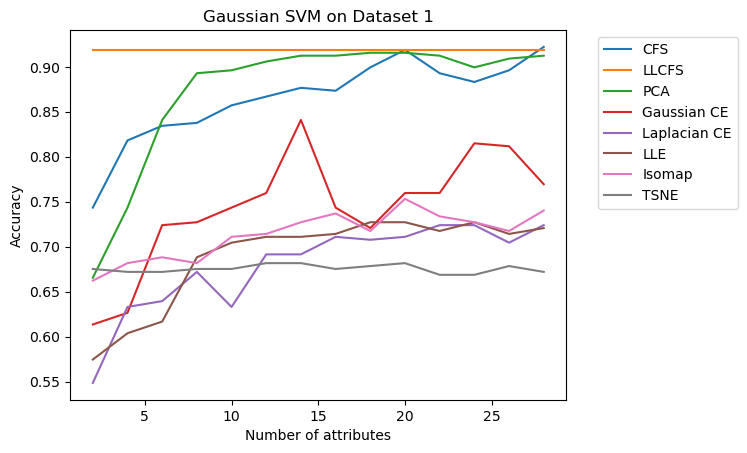

In [37]:
r0, r1,r2,r3,r4,r5,r6,r7,r8  = [],[],[],[],[],[],[],[],[]
for sim in All:
    r0.append(sim)
    r1.append(All[sim][0][0])
    r2.append(All[sim][1][0])
    r3.append(All[sim][2][0])
    r4.append(All[sim][3][0])
    r5.append(All[sim][4][0])
    r6.append(All[sim][5][0])
    r7.append(All[sim][6][0])
    r8.append(All[sim][7][0])

fdf = pd.DataFrame({'Number of attributes': r0, 
                    'CFS': r1, 
                    'LLCFS': r2, 
                    'PCA':r3, 
                    'Gaussian CE': r4,
                    'Laplacian CE': r5, 
                    'LLE': r6, 
                    'Isomap': r7, 
                    'TSNE':r8})

import matplotlib.pyplot as plt
fdf.plot(x='Number of attributes', y=['CFS', 'LLCFS', 'PCA', 'Gaussian CE', 'Laplacian CE', 'LLE', 'Isomap', 'TSNE',])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Accuracy')
plt.title("Gaussian SVM on Dataset 1")
plt.show()

In [24]:
NoF = 25 # Number of features
X2s = [d(X2, np.ravel(Y2), NoF) for d in DR]

results2 = [predict(x2, np.ravel(Y2), [Logistic]) for x2 in X2s]
finals = []
for i in range(len(DR)):
    rd = DR_TXT[i]
    acc, sen, spe = [],[],[]
    for a, s, e in results2[i]:
        acc.append(a)
        sen.append(s)
        spe.append(e)
    finals.append(pd.DataFrame({'model': ['Logistic'],'accuracy': acc, 'sensitivity': sen, 'specificity': spe}))
    
    
finalR = {}
for i in ['Logistic']:
    D = pd.DataFrame() # create an empty DataFrame to hold the filtered rows     
    for df in finals:
        row = df[df['model'] == i]
        D = D.append(row) # filter rows that match a certain condition and append them to D
    D['DR'] = DR_TXT
    D = D.drop('model', axis=1)
    finalR[i] = D

for i in finalR:
    print(i)
    print(finalR[i][['DR', 'accuracy' , 'sensitivity',  'specificity']])
    print()

D:\Documents\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


[9.68713086e-01 2.74234961e-02 1.81937840e-03 7.64856806e-04
 5.10486842e-04 2.95086213e-04 1.99060233e-04 1.07638969e-04
 8.67742844e-05 3.23837027e-05 1.76585343e-05 1.28489755e-05
 4.04401212e-06 3.54801270e-06 2.88068144e-06 2.62541850e-06
 2.14270955e-06 1.17896369e-06 2.54867404e-07 1.58914087e-07
 1.03668102e-07 7.68200538e-08 6.24574875e-08 5.89534241e-08
 3.44613336e-08]


D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Documents\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Logistic
          DR  accuracy  sensitivity  specificity
0        CFS  0.940439     0.893412     0.928065
0      LLCFS  0.989028     0.979953     0.990475
0  PCA_model  0.976489     0.953977     0.978789
0   CE_Model  0.774295     0.331989     0.665488
0        CE2  0.782132     0.348491     0.682342
0        LLE  0.791536     0.450758     0.728193
0     Isomap  0.780564     0.363589     0.692082
0       TSNE  0.777429     0.333333     0.666667



In [ ]:
print(X2.shape)
All = {}
for NoF in range (2, X2.shape[1], 2): # Number of features
    X1s = [d(X2, np.ravel(Y2), NoF) for d in DR] # dimension reduction
    results1 = [predict(x, np.ravel(Y2), [Logistic])[0] for x in X1s] # Machine learning models
    All[NoF] = results1
    

print('complete.....\n\n')

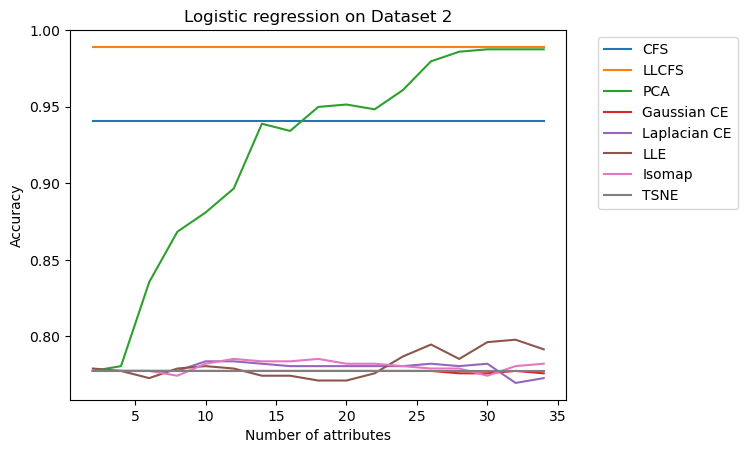

In [30]:
r0, r1,r2,r3,r4,r5,r6,r7,r8  = [],[],[],[],[],[],[],[],[]
for sim in All:
    r0.append(sim)
    r1.append(All[sim][0][0])
    r2.append(All[sim][1][0])
    r3.append(All[sim][2][0])
    r4.append(All[sim][3][0])
    r5.append(All[sim][4][0])
    r6.append(All[sim][5][0])
    r7.append(All[sim][6][0])
    r8.append(All[sim][7][0])

fdf = pd.DataFrame({'Number of attributes': r0, 
                    'CFS': r1, 
                    'LLCFS': r2, 
                    'PCA':r3, 
                    'Gaussian CE': r4,
                    'Laplacian CE': r5, 
                    'LLE': r6, 
                    'Isomap': r7, 
                    'TSNE':r8})
fdf
import matplotlib.pyplot as plt
fdf.plot(x='Number of attributes', y=['CFS', 'LLCFS', 'PCA', 'Gaussian CE', 'Laplacian CE', 'LLE', 'Isomap', 'TSNE',])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Accuracy')
plt.title("Logistic regression on Dataset 2")
plt.show()


In [33]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.datasets import load_boston

# Load the Boston Housing dataset
X, y = load_boston(return_X_y=True)

# Select the top 5 features using SelectKBest with f_regression
selector = SelectKBest(score_func=f_regression, k=5)
X_new = selector.fit_transform(X, y)

# Print the indices of the selected features
print(selector.get_support(indices=True))
X_new

[ 2  5  9 10 12]


D:\Documents\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.

array([[  2.31 ,   6.575, 296.   ,  15.3  ,   4.98 ],
       [  7.07 ,   6.421, 242.   ,  17.8  ,   9.14 ],
       [  7.07 ,   7.185, 242.   ,  17.8  ,   4.03 ],
       ...,
       [ 11.93 ,   6.976, 273.   ,  21.   ,   5.64 ],
       [ 11.93 ,   6.794, 273.   ,  21.   ,   6.48 ],
       [ 11.93 ,   6.03 , 273.   ,  21.   ,   7.88 ]])